In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
import json, re, glob,random
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def write_list(a_list):
    print("Started writing list data into a json file")
    with open("Fourhit_processes_inc_neutrality/dataset_division/train_and_test_filenames_in_order_22092023.json", "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")

# Read list to memory
def read_list():
    # for reading also binary mode is important
    with open('Fourhit_processes_inc_neutrality/dataset_division/train_and_test_filenames_in_order_22092023.json', 'rb') as fp:
        n_list = json.load(fp)
        return n_list
    
# write_list(files)
files = read_list()

In [5]:
class MyDataset(Dataset):
    def __init__(self, dataset='train', transform=None, target_transform=None):
        map = {'s0/mu10minus4':0, 's15/mu10minus4':1, 's30/mu10minus4':2,\
              's0/mu10minus5':3, 's15/mu10minus5':4, 's30/mu10minus5':5}
        
            

        def reading_in_data_with_sb(f):
            N =10**5 
            res = json.load(open(f))
            list_of_cell_numbers = res[0:4] 
#             print('list_of_cell_numbers', list_of_cell_numbers)
            list_of_probabilities = [c/N for c in list_of_cell_numbers]     
            if sum(list_of_cell_numbers)<N:
#                 print(sum(list_of_cell_numbers))
                list_of_probabilities.append((N-sum(list_of_cell_numbers))/N)
#                 print(list_of_probabilities, sum(list_of_probabilities))
            normalized_list_of_probabilities = [c/sum(list_of_probabilities) for c in list_of_probabilities]  
            sampled_cell_num = 300
            list_of_subsampled_cell_numbers = np.random.multinomial(sampled_cell_num, normalized_list_of_probabilities, 1)[0]
        #             print('list_of_subsampled_cell_numbers', list_of_subsampled_cell_numbers)

            return list_of_subsampled_cell_numbers[0:4]
        
        self.data = torch.Tensor([reading_in_data_with_sb(f) for f in files ])
        self.label = torch.Tensor([ map[f.split('_')[4][:-1]+'/'+f.split('_')[5][:-7]] for f in files])
        self.label = self.label.type(torch.LongTensor)
        self.transform = transform
        
        if dataset == 'train':
            self.data = self.data[:3334]
            self.label = self.label[:3334]
        else:
            self.data = self.data[3334:]
            self.label = self.label[3334:]
            
        
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

training_data = MyDataset('train')
testing_data = MyDataset('test')
training_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=16, shuffle=True)

C:\Users\chickchick\AppData\Local\Temp\ipykernel_34580\1714867199.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  self.data = torch.Tensor([reading_in_data_with_sb(f) for f in files ])


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
        )
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
#                 torch.nn.init.xavier_uniform_(m.weight)
                torch.nn.init.kaiming_uniform_(m.weight)

#                 n = m.in_features
#                 y = 1.0/np.sqrt(n)
#                 m.weight.data.uniform_(-y, y)
#                 m.bias.data.fill_(0)
                
#                 m.weight.data.normal_(0.0,y)
                
        self.linear_relu_stack.apply(init_weights)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for idx, (x,y) in enumerate(dataloader):
    #     # Compute prediction and loss
    #     print (idx)
        pred = model(x)
        loss = loss_fn(pred, y)
#         if idx == 1:
#             print('pred:', pred[:].argmax(1))
#             print('y',y)

    #     # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if idx % 100 == 0:
#             loss, current = loss.item(), idx * len(x)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# def test_loop(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     with torch.no_grad():
#         for x, y in dataloader:
#             pred = model(x)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
#     print(correct)
#     return correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(correct)
    return correct, test_loss

def test_loop_picking_out_correct_trees(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    num = 0
    with torch.no_grad():
        for x, y in dataloader:
            num += 16
            pred = model(x)
#             print('x is', x,'pred is', pred)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#             print( 'x',x[pred.argmax(1) != y], 'was misclassified from y', y[pred.argmax(1) != y])
            for LABEL, tree in zip(y[pred.argmax(1) != y], x[pred.argmax(1) != y]):
                wrong_trees[LABEL] = tree
            for LABEL, tree in zip(y[pred.argmax(1) == y], x[pred.argmax(1) == y]):
                correct_trees[LABEL] = tree
            for truth, prediction in zip(y, pred.argmax(1)):
                confusion_matrix[prediction][truth] += 1
#                 if num == 12576:
#                     print('prediction', prediction, 'truth', truth, 'confusion_matrix[prediction][truth]', confusion_matrix[prediction][truth])

    test_loss /= num_batches
    correct /= size
    print('num', num)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(correct)
    return correct

def confusion_matrix(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(correct)
    return correct

In [9]:
from random import *

# seed = randint(1, 100)
# torch.manual_seed(seed)
model = NeuralNetwork()
learning_rate = 10**-8
# models 01082023, 02082023, 03082023, 04082023, 05082023 use learning_rate = 5*10**-9
# models 06082023, 07082023, 08082023, 09082023, 10082023 use learning_rate = 10**-9
# learning_rate = 10**-9
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
accuracy_trajectory = []
loss_trajectory = []
for i in range(10001):
    print('epoch:', i)
    train_loop(training_dataloader, model, loss_fn, optimizer)
    acc, test_loss = test_loop(testing_dataloader, model, loss_fn)

    if i %1000==0:
        torch.save(model.state_dict(), 'stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_alpha10minus8_randomseed_11_data_epoch_'+str(i)+'.pt')
    accuracy_trajectory.append(acc)
    loss_trajectory.append(test_loss)

epoch: 0
Test Error: 
 Accuracy: 22.0%, Avg loss: 95.840275 

0.21968787515006002
epoch: 1
Test Error: 
 Accuracy: 20.6%, Avg loss: 91.461762 

0.20588235294117646
epoch: 2
Test Error: 
 Accuracy: 20.5%, Avg loss: 89.482514 

0.20528211284513806
epoch: 3
Test Error: 
 Accuracy: 20.6%, Avg loss: 83.645824 

0.2064825930372149
epoch: 4
Test Error: 
 Accuracy: 20.8%, Avg loss: 80.156820 

0.20768307322929172
epoch: 5
Test Error: 
 Accuracy: 20.7%, Avg loss: 76.861558 

0.2070828331332533
epoch: 6
Test Error: 
 Accuracy: 20.8%, Avg loss: 72.923638 

0.20768307322929172
epoch: 7
Test Error: 
 Accuracy: 20.8%, Avg loss: 69.029116 

0.20768307322929172
epoch: 8
Test Error: 
 Accuracy: 20.8%, Avg loss: 65.476885 

0.20828331332533012
epoch: 9
Test Error: 
 Accuracy: 20.9%, Avg loss: 61.007468 

0.20888355342136855
epoch: 10
Test Error: 
 Accuracy: 20.8%, Avg loss: 57.487778 

0.20828331332533012
epoch: 11
Test Error: 
 Accuracy: 20.8%, Avg loss: 54.021014 

0.20828331332533012
epoch: 12
Test E

Test Error: 
 Accuracy: 50.4%, Avg loss: 9.787699 

0.5042016806722689
epoch: 101
Test Error: 
 Accuracy: 50.5%, Avg loss: 9.258103 

0.5048019207683073
epoch: 102
Test Error: 
 Accuracy: 50.6%, Avg loss: 9.262696 

0.5060024009603842
epoch: 103
Test Error: 
 Accuracy: 50.7%, Avg loss: 9.202501 

0.507202881152461
epoch: 104
Test Error: 
 Accuracy: 50.8%, Avg loss: 9.164352 

0.5084033613445378
epoch: 105
Test Error: 
 Accuracy: 51.0%, Avg loss: 9.141595 

0.5102040816326531
epoch: 106
Test Error: 
 Accuracy: 51.0%, Avg loss: 9.093362 

0.5102040816326531
epoch: 107
Test Error: 
 Accuracy: 51.0%, Avg loss: 9.062971 

0.5102040816326531
epoch: 108
Test Error: 
 Accuracy: 51.2%, Avg loss: 9.032292 

0.5120048019207684
epoch: 109
Test Error: 
 Accuracy: 51.2%, Avg loss: 9.078031 

0.5120048019207684
epoch: 110
Test Error: 
 Accuracy: 51.1%, Avg loss: 9.254040 

0.5108043217286915
epoch: 111
Test Error: 
 Accuracy: 51.3%, Avg loss: 9.093749 

0.5132052821128451
epoch: 112
Test Error: 
 Acc

Test Error: 
 Accuracy: 50.9%, Avg loss: 7.262947 

0.5090036014405762
epoch: 201
Test Error: 
 Accuracy: 51.3%, Avg loss: 7.243334 

0.5126050420168067
epoch: 202
Test Error: 
 Accuracy: 51.3%, Avg loss: 7.231751 

0.5126050420168067
epoch: 203
Test Error: 
 Accuracy: 51.3%, Avg loss: 7.235836 

0.5126050420168067
epoch: 204
Test Error: 
 Accuracy: 51.3%, Avg loss: 7.218544 

0.5126050420168067
epoch: 205
Test Error: 
 Accuracy: 51.2%, Avg loss: 7.211499 

0.5120048019207684
epoch: 206
Test Error: 
 Accuracy: 51.1%, Avg loss: 7.186308 

0.5114045618247299
epoch: 207
Test Error: 
 Accuracy: 51.2%, Avg loss: 7.180231 

0.5120048019207684
epoch: 208
Test Error: 
 Accuracy: 51.2%, Avg loss: 7.183252 

0.5120048019207684
epoch: 209
Test Error: 
 Accuracy: 51.1%, Avg loss: 7.154688 

0.5114045618247299
epoch: 210
Test Error: 
 Accuracy: 50.8%, Avg loss: 7.137469 

0.5078031212484994
epoch: 211
Test Error: 
 Accuracy: 51.3%, Avg loss: 7.233791 

0.5126050420168067
epoch: 212
Test Error: 
 Ac

Test Error: 
 Accuracy: 51.7%, Avg loss: 6.251847 

0.517406962785114
epoch: 302
Test Error: 
 Accuracy: 51.5%, Avg loss: 6.669210 

0.5150060024009604
epoch: 303
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.244739 

0.5162064825930373
epoch: 304
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.230795 

0.5162064825930373
epoch: 305
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.221165 

0.5162064825930373
epoch: 306
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.220669 

0.5156062424969988
epoch: 307
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.198464 

0.5156062424969988
epoch: 308
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.189517 

0.5156062424969988
epoch: 309
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.592921 

0.5156062424969988
epoch: 310
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.284282 

0.5162064825930373
epoch: 311
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.174755 

0.5162064825930373
epoch: 312
Test Error: 
 Accuracy: 51.6%, Avg loss: 6.166477 

0.5162064825930373
epoch: 313
Test Error: 
 Acc

Test Error: 
 Accuracy: 51.9%, Avg loss: 5.487877 

0.5186074429771909
epoch: 402
Test Error: 
 Accuracy: 51.8%, Avg loss: 5.476747 

0.5180072028811524
epoch: 403
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.473319 

0.517406962785114
epoch: 404
Test Error: 
 Accuracy: 51.8%, Avg loss: 5.458747 

0.5180072028811524
epoch: 405
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.453703 

0.517406962785114
epoch: 406
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.479596 

0.517406962785114
epoch: 407
Test Error: 
 Accuracy: 51.8%, Avg loss: 5.491966 

0.5180072028811524
epoch: 408
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.438745 

0.517406962785114
epoch: 409
Test Error: 
 Accuracy: 51.8%, Avg loss: 5.452455 

0.5180072028811524
epoch: 410
Test Error: 
 Accuracy: 51.9%, Avg loss: 5.480349 

0.5186074429771909
epoch: 411
Test Error: 
 Accuracy: 51.8%, Avg loss: 5.409260 

0.5180072028811524
epoch: 412
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.405240 

0.517406962785114
epoch: 413
Test Error: 
 Accurac

Test Error: 
 Accuracy: 51.7%, Avg loss: 4.800402 

0.5168067226890757
epoch: 503
Test Error: 
 Accuracy: 51.6%, Avg loss: 4.793678 

0.5162064825930373
epoch: 504
Test Error: 
 Accuracy: 51.7%, Avg loss: 4.792942 

0.5168067226890757
epoch: 505
Test Error: 
 Accuracy: 51.7%, Avg loss: 5.011297 

0.5168067226890757
epoch: 506
Test Error: 
 Accuracy: 52.0%, Avg loss: 4.775027 

0.5198079231692677
epoch: 507
Test Error: 
 Accuracy: 51.5%, Avg loss: 4.796649 

0.5150060024009604
epoch: 508
Test Error: 
 Accuracy: 51.7%, Avg loss: 4.788721 

0.5168067226890757
epoch: 509
Test Error: 
 Accuracy: 51.6%, Avg loss: 4.770746 

0.5156062424969988
epoch: 510
Test Error: 
 Accuracy: 52.0%, Avg loss: 4.779875 

0.5198079231692677
epoch: 511
Test Error: 
 Accuracy: 52.0%, Avg loss: 4.757679 

0.5198079231692677
epoch: 512
Test Error: 
 Accuracy: 51.8%, Avg loss: 4.735736 

0.5180072028811524
epoch: 513
Test Error: 
 Accuracy: 51.8%, Avg loss: 4.732169 

0.5180072028811524
epoch: 514
Test Error: 
 Ac

Test Error: 
 Accuracy: 52.1%, Avg loss: 4.155029 

0.5210084033613446
epoch: 604
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.165188 

0.521608643457383
epoch: 605
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.133027 

0.521608643457383
epoch: 606
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.147810 

0.521608643457383
epoch: 607
Test Error: 
 Accuracy: 52.0%, Avg loss: 4.113017 

0.5204081632653061
epoch: 608
Test Error: 
 Accuracy: 52.1%, Avg loss: 4.138062 

0.5210084033613446
epoch: 609
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.106817 

0.5222088835534213
epoch: 610
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.094366 

0.521608643457383
epoch: 611
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.103473 

0.5222088835534213
epoch: 612
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.115762 

0.5222088835534213
epoch: 613
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.101579 

0.521608643457383
epoch: 614
Test Error: 
 Accuracy: 52.2%, Avg loss: 4.073006 

0.521608643457383
epoch: 615
Test Error: 
 Accuracy

Test Error: 
 Accuracy: 52.4%, Avg loss: 3.563741 

0.5240096038415366
epoch: 705
Test Error: 
 Accuracy: 52.5%, Avg loss: 3.545318 

0.524609843937575
epoch: 706
Test Error: 
 Accuracy: 52.5%, Avg loss: 3.532374 

0.5252100840336135
epoch: 707
Test Error: 
 Accuracy: 52.6%, Avg loss: 3.532753 

0.5264105642256903
epoch: 708
Test Error: 
 Accuracy: 52.5%, Avg loss: 3.575533 

0.5252100840336135
epoch: 709
Test Error: 
 Accuracy: 52.5%, Avg loss: 3.516188 

0.5252100840336135
epoch: 710
Test Error: 
 Accuracy: 52.6%, Avg loss: 3.554761 

0.5264105642256903
epoch: 711
Test Error: 
 Accuracy: 52.7%, Avg loss: 3.514859 

0.5270108043217286
epoch: 712
Test Error: 
 Accuracy: 52.6%, Avg loss: 3.518313 

0.5264105642256903
epoch: 713
Test Error: 
 Accuracy: 52.7%, Avg loss: 3.504549 

0.5270108043217286
epoch: 714
Test Error: 
 Accuracy: 52.6%, Avg loss: 3.503849 

0.5264105642256903
epoch: 715
Test Error: 
 Accuracy: 52.7%, Avg loss: 3.484809 

0.5270108043217286
epoch: 716
Test Error: 
 Acc

Test Error: 
 Accuracy: 53.2%, Avg loss: 3.196854 

0.531812725090036
epoch: 805
Test Error: 
 Accuracy: 53.1%, Avg loss: 3.193557 

0.5306122448979592
epoch: 806
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.185286 

0.5324129651860744
epoch: 807
Test Error: 
 Accuracy: 53.0%, Avg loss: 3.189710 

0.5300120048019208
epoch: 808
Test Error: 
 Accuracy: 53.1%, Avg loss: 3.193150 

0.5306122448979592
epoch: 809
Test Error: 
 Accuracy: 53.1%, Avg loss: 3.203611 

0.5312124849939976
epoch: 810
Test Error: 
 Accuracy: 53.1%, Avg loss: 3.180643 

0.5306122448979592
epoch: 811
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.170682 

0.531812725090036
epoch: 812
Test Error: 
 Accuracy: 53.1%, Avg loss: 3.319625 

0.5306122448979592
epoch: 813
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.165704 

0.531812725090036
epoch: 814
Test Error: 
 Accuracy: 53.0%, Avg loss: 3.175208 

0.5300120048019208
epoch: 815
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.166766 

0.531812725090036
epoch: 816
Test Error: 
 Accura

Test Error: 
 Accuracy: 53.2%, Avg loss: 2.929672 

0.5324129651860744
epoch: 906
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.069995 

0.5324129651860744
epoch: 907
Test Error: 
 Accuracy: 53.3%, Avg loss: 3.256170 

0.5330132052821128
epoch: 908
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.917831 

0.5336134453781513
epoch: 909
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.201037 

0.531812725090036
epoch: 910
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.914646 

0.5324129651860744
epoch: 911
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.904368 

0.5324129651860744
epoch: 912
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.902979 

0.5324129651860744
epoch: 913
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.906883 

0.5324129651860744
epoch: 914
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.924121 

0.5324129651860744
epoch: 915
Test Error: 
 Accuracy: 53.2%, Avg loss: 3.011753 

0.531812725090036
epoch: 916
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.909154 

0.5324129651860744
epoch: 917
Test Error: 
 Accu

Test Error: 
 Accuracy: 53.2%, Avg loss: 2.710793 

0.5324129651860744
epoch: 1007
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.688147 

0.5348139255702281
epoch: 1008
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.689157 

0.536014405762305
epoch: 1009
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.680646 

0.5336134453781513
epoch: 1010
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.687142 

0.5354141656662665
epoch: 1011
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.674707 

0.5354141656662665
epoch: 1012
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.671162 

0.5348139255702281
epoch: 1013
Test Error: 
 Accuracy: 53.7%, Avg loss: 2.670291 

0.5366146458583433
epoch: 1014
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.667807 

0.5336134453781513
epoch: 1015
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.673681 

0.5348139255702281
epoch: 1016
Test Error: 
 Accuracy: 53.3%, Avg loss: 2.665558 

0.5330132052821128
epoch: 1017
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.672449 

0.5342136854741897
epoch: 1018
Test 

Test Error: 
 Accuracy: 53.5%, Avg loss: 2.497686 

0.5348139255702281
epoch: 1106
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.547019 

0.5354141656662665
epoch: 1107
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.505610 

0.5348139255702281
epoch: 1108
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.499681 

0.5354141656662665
epoch: 1109
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.491167 

0.5354141656662665
epoch: 1110
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.488405 

0.5354141656662665
epoch: 1111
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.490247 

0.5336134453781513
epoch: 1112
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.483536 

0.5342136854741897
epoch: 1113
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.477908 

0.5354141656662665
epoch: 1114
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.479914 

0.5336134453781513
epoch: 1115
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.618918 

0.5354141656662665
epoch: 1116
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.474008 

0.5354141656662665
epoch: 1117
Test

Test Error: 
 Accuracy: 53.1%, Avg loss: 2.338865 

0.5312124849939976
epoch: 1205
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.340224 

0.5312124849939976
epoch: 1206
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.342681 

0.5306122448979592
epoch: 1207
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.338778 

0.531812725090036
epoch: 1208
Test Error: 
 Accuracy: 53.3%, Avg loss: 2.322583 

0.5330132052821128
epoch: 1209
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.323047 

0.531812725090036
epoch: 1210
Test Error: 
 Accuracy: 53.3%, Avg loss: 2.325558 

0.5330132052821128
epoch: 1211
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.319620 

0.5312124849939976
epoch: 1212
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.317177 

0.5312124849939976
epoch: 1213
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.324063 

0.5312124849939976
epoch: 1214
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.396896 

0.531812725090036
epoch: 1215
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.321689 

0.5312124849939976
epoch: 1216
Test Er

Test Error: 
 Accuracy: 52.8%, Avg loss: 2.278889 

0.5282112845138055
epoch: 1304
Test Error: 
 Accuracy: 52.9%, Avg loss: 2.335174 

0.5288115246098439
epoch: 1305
Test Error: 
 Accuracy: 52.8%, Avg loss: 2.212502 

0.5276110444177671
epoch: 1306
Test Error: 
 Accuracy: 52.8%, Avg loss: 2.208300 

0.5276110444177671
epoch: 1307
Test Error: 
 Accuracy: 52.8%, Avg loss: 2.240331 

0.5282112845138055
epoch: 1308
Test Error: 
 Accuracy: 52.6%, Avg loss: 2.226144 

0.5264105642256903
epoch: 1309
Test Error: 
 Accuracy: 52.7%, Avg loss: 2.194110 

0.5270108043217286
epoch: 1310
Test Error: 
 Accuracy: 52.6%, Avg loss: 2.216274 

0.5264105642256903
epoch: 1311
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.239714 

0.5306122448979592
epoch: 1312
Test Error: 
 Accuracy: 52.8%, Avg loss: 2.193431 

0.5282112845138055
epoch: 1313
Test Error: 
 Accuracy: 52.9%, Avg loss: 2.212469 

0.5294117647058824
epoch: 1314
Test Error: 
 Accuracy: 53.0%, Avg loss: 2.193932 

0.5300120048019208
epoch: 1315
Test

Test Error: 
 Accuracy: 53.5%, Avg loss: 2.093615 

0.5354141656662665
epoch: 1403
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.103122 

0.5348139255702281
epoch: 1404
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.089666 

0.5342136854741897
epoch: 1405
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.105708 

0.5354141656662665
epoch: 1406
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.097253 

0.5354141656662665
epoch: 1407
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.110085 

0.5354141656662665
epoch: 1408
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.099557 

0.536014405762305
epoch: 1409
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.095330 

0.5348139255702281
epoch: 1410
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.165374 

0.5354141656662665
epoch: 1411
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.097921 

0.536014405762305
epoch: 1412
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.092075 

0.5354141656662665
epoch: 1413
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.097584 

0.5348139255702281
epoch: 1414
Test E

Test Error: 
 Accuracy: 53.4%, Avg loss: 2.021858 

0.5336134453781513
epoch: 1502
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.006024 

0.5354141656662665
epoch: 1503
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.005791 

0.5354141656662665
epoch: 1504
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.007434 

0.536014405762305
epoch: 1505
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.006096 

0.5354141656662665
epoch: 1506
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.005988 

0.5354141656662665
epoch: 1507
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.997734 

0.5348139255702281
epoch: 1508
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.005022 

0.536014405762305
epoch: 1509
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.011308 

0.5336134453781513
epoch: 1510
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.002347 

0.5342136854741897
epoch: 1511
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.009315 

0.5354141656662665
epoch: 1512
Test Error: 
 Accuracy: 53.5%, Avg loss: 2.006186 

0.5354141656662665
epoch: 1513
Test E

Test Error: 
 Accuracy: 53.8%, Avg loss: 1.930547 

0.5384153661464586
epoch: 1601
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.924189 

0.5372148859543817
epoch: 1602
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.927110 

0.5366146458583433
epoch: 1603
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.938274 

0.5372148859543817
epoch: 1604
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.928927 

0.5378151260504201
epoch: 1605
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.922457 

0.536014405762305
epoch: 1606
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.921057 

0.536014405762305
epoch: 1607
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.919012 

0.5384153661464586
epoch: 1608
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.928252 

0.5372148859543817
epoch: 1609
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.949318 

0.5378151260504201
epoch: 1610
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.921560 

0.5372148859543817
epoch: 1611
Test Error: 
 Accuracy: 53.6%, Avg loss: 2.042945 

0.536014405762305
epoch: 1612
Test Er

Test Error: 
 Accuracy: 53.3%, Avg loss: 1.870452 

0.5330132052821128
epoch: 1700
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.863042 

0.5336134453781513
epoch: 1701
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.970907 

0.5342136854741897
epoch: 1702
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.858771 

0.5342136854741897
epoch: 1703
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.869364 

0.5348139255702281
epoch: 1704
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.855390 

0.536014405762305
epoch: 1705
Test Error: 
 Accuracy: 53.4%, Avg loss: 2.004346 

0.5342136854741897
epoch: 1706
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.855734 

0.5354141656662665
epoch: 1707
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.855815 

0.5348139255702281
epoch: 1708
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.922075 

0.5354141656662665
epoch: 1709
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.854145 

0.5342136854741897
epoch: 1710
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.863214 

0.5342136854741897
epoch: 1711
Test 

Test Error: 
 Accuracy: 53.7%, Avg loss: 1.807558 

0.5372148859543817
epoch: 1799
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.792681 

0.5378151260504201
epoch: 1800
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.796010 

0.5372148859543817
epoch: 1801
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.790503 

0.5378151260504201
epoch: 1802
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.803719 

0.5378151260504201
epoch: 1803
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.797151 

0.5372148859543817
epoch: 1804
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.841383 

0.5366146458583433
epoch: 1805
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.792807 

0.5372148859543817
epoch: 1806
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.787767 

0.5378151260504201
epoch: 1807
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.814903 

0.5372148859543817
epoch: 1808
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.787849 

0.5378151260504201
epoch: 1809
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.811118 

0.5372148859543817
epoch: 1810
Test

Test Error: 
 Accuracy: 53.7%, Avg loss: 1.754980 

0.5372148859543817
epoch: 1898
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.745578 

0.536014405762305
epoch: 1899
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.742771 

0.5366146458583433
epoch: 1900
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.738841 

0.5366146458583433
epoch: 1901
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.748592 

0.536014405762305
epoch: 1902
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.735512 

0.5354141656662665
epoch: 1903
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.755978 

0.5372148859543817
epoch: 1904
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.905706 

0.5354141656662665
epoch: 1905
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.754775 

0.536014405762305
epoch: 1906
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.738642 

0.5354141656662665
epoch: 1907
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.737250 

0.5366146458583433
epoch: 1908
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.738246 

0.5366146458583433
epoch: 1909
Test Er

Test Error: 
 Accuracy: 53.7%, Avg loss: 1.689772 

0.5372148859543817
epoch: 1997
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.713571 

0.5384153661464586
epoch: 1998
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.700776 

0.5378151260504201
epoch: 1999
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.697569 

0.5378151260504201
epoch: 2000
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.709517 

0.5366146458583433
epoch: 2001
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.686089 

0.536014405762305
epoch: 2002
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.720443 

0.5384153661464586
epoch: 2003
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.693111 

0.5372148859543817
epoch: 2004
Test Error: 
 Accuracy: 53.9%, Avg loss: 1.687472 

0.539015606242497
epoch: 2005
Test Error: 
 Accuracy: 53.9%, Avg loss: 1.691561 

0.539015606242497
epoch: 2006
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.746031 

0.536014405762305
epoch: 2007
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.687486 

0.5378151260504201
epoch: 2008
Test Err

Test Error: 
 Accuracy: 54.1%, Avg loss: 1.656437 

0.5408163265306123
epoch: 2096
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.650502 

0.5402160864345739
epoch: 2097
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.645065 

0.5402160864345739
epoch: 2098
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.651386 

0.5396158463385354
epoch: 2099
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.671207 

0.5402160864345739
epoch: 2100
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.645010 

0.5414165666266506
epoch: 2101
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.648576 

0.5414165666266506
epoch: 2102
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.648336 

0.5408163265306123
epoch: 2103
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.650206 

0.5414165666266506
epoch: 2104
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.663377 

0.5408163265306123
epoch: 2105
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.639030 

0.5414165666266506
epoch: 2106
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.653353 

0.5414165666266506
epoch: 2107
Test

Test Error: 
 Accuracy: 54.3%, Avg loss: 1.603356 

0.5426170468187275
epoch: 2196
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.607355 

0.5426170468187275
epoch: 2197
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.688598 

0.542016806722689
epoch: 2198
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.642716 

0.542016806722689
epoch: 2199
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.606375 

0.542016806722689
epoch: 2200
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.656873 

0.542016806722689
epoch: 2201
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.605437 

0.542016806722689
epoch: 2202
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.601996 

0.5432172869147659
epoch: 2203
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.607295 

0.542016806722689
epoch: 2204
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.607360 

0.5432172869147659
epoch: 2205
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.600892 

0.5414165666266506
epoch: 2206
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.610796 

0.5396158463385354
epoch: 2207
Test Error

Test Error: 
 Accuracy: 54.4%, Avg loss: 1.595218 

0.5438175270108043
epoch: 2295
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.617807 

0.5426170468187275
epoch: 2296
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.571269 

0.5450180072028812
epoch: 2297
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.563495 

0.542016806722689
epoch: 2298
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.583683 

0.5438175270108043
epoch: 2299
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.573747 

0.5432172869147659
epoch: 2300
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.593480 

0.5426170468187275
epoch: 2301
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.562794 

0.5432172869147659
epoch: 2302
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.568493 

0.5426170468187275
epoch: 2303
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.574823 

0.5414165666266506
epoch: 2304
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.574283 

0.5432172869147659
epoch: 2305
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.567777 

0.542016806722689
epoch: 2306
Test E

Test Error: 
 Accuracy: 54.2%, Avg loss: 1.534357 

0.542016806722689
epoch: 2394
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.533708 

0.542016806722689
epoch: 2395
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.546453 

0.5438175270108043
epoch: 2396
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.534759 

0.5432172869147659
epoch: 2397
Test Error: 
 Accuracy: 54.6%, Avg loss: 1.531934 

0.5456182472989196
epoch: 2398
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.569030 

0.5450180072028812
epoch: 2399
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.540208 

0.5408163265306123
epoch: 2400
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.588003 

0.5444177671068428
epoch: 2401
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.535010 

0.5432172869147659
epoch: 2402
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.533382 

0.5426170468187275
epoch: 2403
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.534615 

0.5444177671068428
epoch: 2404
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.532906 

0.5426170468187275
epoch: 2405
Test E

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.531270 

0.5528211284513805
epoch: 2493
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.500496 

0.553421368547419
epoch: 2494
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.508100 

0.5558223289315727
epoch: 2495
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.496728 

0.553421368547419
epoch: 2496
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.559242 

0.5552220888355343
epoch: 2497
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.499327 

0.553421368547419
epoch: 2498
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.499022 

0.5558223289315727
epoch: 2499
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.505619 

0.5540216086434574
epoch: 2500
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.510277 

0.5558223289315727
epoch: 2501
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.557184 

0.5552220888355343
epoch: 2502
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.494189 

0.5558223289315727
epoch: 2503
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.504782 

0.5558223289315727
epoch: 2504
Test Er

Test Error: 
 Accuracy: 55.6%, Avg loss: 1.477767 

0.556422569027611
epoch: 2593
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.469297 

0.5558223289315727
epoch: 2594
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.536851 

0.5540216086434574
epoch: 2595
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.474456 

0.5558223289315727
epoch: 2596
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.467292 

0.5546218487394958
epoch: 2597
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.465892 

0.5540216086434574
epoch: 2598
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.465346 

0.5546218487394958
epoch: 2599
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.473689 

0.5546218487394958
epoch: 2600
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.478553 

0.5546218487394958
epoch: 2601
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.486730 

0.5570228091236494
epoch: 2602
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.471668 

0.5558223289315727
epoch: 2603
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.467382 

0.5570228091236494
epoch: 2604
Test 

Test Error: 
 Accuracy: 55.4%, Avg loss: 1.446947 

0.5540216086434574
epoch: 2692
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.450593 

0.5546218487394958
epoch: 2693
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.496659 

0.5546218487394958
epoch: 2694
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.444859 

0.553421368547419
epoch: 2695
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.447211 

0.5552220888355343
epoch: 2696
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.455069 

0.5540216086434574
epoch: 2697
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.453280 

0.5582232893157263
epoch: 2698
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.439315 

0.5558223289315727
epoch: 2699
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.444617 

0.5546218487394958
epoch: 2700
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.439345 

0.5558223289315727
epoch: 2701
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.444339 

0.5552220888355343
epoch: 2702
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.444244 

0.5552220888355343
epoch: 2703
Test 

Test Error: 
 Accuracy: 55.4%, Avg loss: 1.418862 

0.5540216086434574
epoch: 2791
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.423326 

0.5546218487394958
epoch: 2792
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.420341 

0.5546218487394958
epoch: 2793
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.423463 

0.5552220888355343
epoch: 2794
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.459438 

0.5546218487394958
epoch: 2795
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.420283 

0.5540216086434574
epoch: 2796
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.426818 

0.5558223289315727
epoch: 2797
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.423611 

0.5546218487394958
epoch: 2798
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.422119 

0.5552220888355343
epoch: 2799
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.424118 

0.5546218487394958
epoch: 2800
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.491637 

0.5546218487394958
epoch: 2801
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.416680 

0.5546218487394958
epoch: 2802
Test

Test Error: 
 Accuracy: 55.5%, Avg loss: 1.406441 

0.5552220888355343
epoch: 2891
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.402288 

0.556422569027611
epoch: 2892
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.405171 

0.5546218487394958
epoch: 2893
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.421103 

0.5546218487394958
epoch: 2894
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.408041 

0.5546218487394958
epoch: 2895
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.398235 

0.5546218487394958
epoch: 2896
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.408237 

0.5540216086434574
epoch: 2897
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.393578 

0.5546218487394958
epoch: 2898
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.397718 

0.5552220888355343
epoch: 2899
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.400914 

0.5546218487394958
epoch: 2900
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.413262 

0.5552220888355343
epoch: 2901
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.459423 

0.5546218487394958
epoch: 2902
Test 

Test Error: 
 Accuracy: 55.4%, Avg loss: 1.385140 

0.5540216086434574
epoch: 2990
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.396932 

0.5540216086434574
epoch: 2991
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.380716 

0.556422569027611
epoch: 2992
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.381965 

0.5546218487394958
epoch: 2993
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.379861 

0.5540216086434574
epoch: 2994
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.385934 

0.5540216086434574
epoch: 2995
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.385035 

0.5558223289315727
epoch: 2996
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.377156 

0.5540216086434574
epoch: 2997
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.373008 

0.5540216086434574
epoch: 2998
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.383785 

0.5546218487394958
epoch: 2999
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.382187 

0.5540216086434574
epoch: 3000
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.372656 

0.5546218487394958
epoch: 3001
Test 

Test Error: 
 Accuracy: 55.5%, Avg loss: 1.366904 

0.5546218487394958
epoch: 3089
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.363560 

0.5546218487394958
epoch: 3090
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.366119 

0.556422569027611
epoch: 3091
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.361431 

0.5540216086434574
epoch: 3092
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.355918 

0.5546218487394958
epoch: 3093
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.355723 

0.5546218487394958
epoch: 3094
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.372015 

0.5546218487394958
epoch: 3095
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.360794 

0.5552220888355343
epoch: 3096
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.354800 

0.5552220888355343
epoch: 3097
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.368583 

0.5552220888355343
epoch: 3098
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.359748 

0.5552220888355343
epoch: 3099
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.367973 

0.5546218487394958
epoch: 3100
Test 

Test Error: 
 Accuracy: 55.5%, Avg loss: 1.349228 

0.5552220888355343
epoch: 3188
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.340490 

0.5552220888355343
epoch: 3189
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.344449 

0.5546218487394958
epoch: 3190
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.347043 

0.5546218487394958
epoch: 3191
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.349075 

0.5552220888355343
epoch: 3192
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.357270 

0.556422569027611
epoch: 3193
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.338901 

0.5552220888355343
epoch: 3194
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.343372 

0.5546218487394958
epoch: 3195
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.343141 

0.5552220888355343
epoch: 3196
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.345053 

0.5546218487394958
epoch: 3197
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.347404 

0.5552220888355343
epoch: 3198
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.337112 

0.5546218487394958
epoch: 3199
Test 

Test Error: 
 Accuracy: 55.5%, Avg loss: 1.330993 

0.5552220888355343
epoch: 3288
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.331525 

0.556422569027611
epoch: 3289
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.323529 

0.556422569027611
epoch: 3290
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.334173 

0.5546218487394958
epoch: 3291
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.326464 

0.556422569027611
epoch: 3292
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.323241 

0.5546218487394958
epoch: 3293
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.341053 

0.5552220888355343
epoch: 3294
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.330685 

0.5540216086434574
epoch: 3295
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.329865 

0.5528211284513805
epoch: 3296
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.327927 

0.5546218487394958
epoch: 3297
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.330542 

0.5546218487394958
epoch: 3298
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.332936 

0.5546218487394958
epoch: 3299
Test Er

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.313915 

0.553421368547419
epoch: 3387
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.324110 

0.553421368547419
epoch: 3388
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.321685 

0.5552220888355343
epoch: 3389
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.335203 

0.5546218487394958
epoch: 3390
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.312462 

0.556422569027611
epoch: 3391
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.310448 

0.5540216086434574
epoch: 3392
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.309718 

0.5546218487394958
epoch: 3393
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.311867 

0.5552220888355343
epoch: 3394
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.317448 

0.553421368547419
epoch: 3395
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.309882 

0.5552220888355343
epoch: 3396
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.317957 

0.5540216086434574
epoch: 3397
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.316807 

0.5546218487394958
epoch: 3398
Test Err

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.298053 

0.553421368547419
epoch: 3487
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.304599 

0.5540216086434574
epoch: 3488
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.318655 

0.5540216086434574
epoch: 3489
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.320129 

0.5546218487394958
epoch: 3490
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.313540 

0.553421368547419
epoch: 3491
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.297556 

0.5540216086434574
epoch: 3492
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.302785 

0.5546218487394958
epoch: 3493
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.303346 

0.5546218487394958
epoch: 3494
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.299429 

0.5540216086434574
epoch: 3495
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.300068 

0.5546218487394958
epoch: 3496
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.307558 

0.5546218487394958
epoch: 3497
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.343088 

0.5546218487394958
epoch: 3498
Test E

Test Error: 
 Accuracy: 55.3%, Avg loss: 1.307744 

0.553421368547419
epoch: 3586
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.289556 

0.553421368547419
epoch: 3587
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.294245 

0.5546218487394958
epoch: 3588
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.291659 

0.5528211284513805
epoch: 3589
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.334791 

0.5528211284513805
epoch: 3590
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.288337 

0.553421368547419
epoch: 3591
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.293709 

0.5540216086434574
epoch: 3592
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.288459 

0.5540216086434574
epoch: 3593
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.286207 

0.5540216086434574
epoch: 3594
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.292776 

0.5546218487394958
epoch: 3595
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.298321 

0.5540216086434574
epoch: 3596
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.293055 

0.5540216086434574
epoch: 3597
Test Er

Test Error: 
 Accuracy: 55.5%, Avg loss: 1.283393 

0.5546218487394958
epoch: 3685
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.289431 

0.5552220888355343
epoch: 3686
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.288421 

0.5540216086434574
epoch: 3687
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.278899 

0.5540216086434574
epoch: 3688
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.281624 

0.5552220888355343
epoch: 3689
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.279474 

0.5540216086434574
epoch: 3690
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.281718 

0.5552220888355343
epoch: 3691
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.276912 

0.5552220888355343
epoch: 3692
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.276582 

0.5546218487394958
epoch: 3693
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.274993 

0.5552220888355343
epoch: 3694
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.276915 

0.5540216086434574
epoch: 3695
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.276229 

0.553421368547419
epoch: 3696
Test 

Test Error: 
 Accuracy: 55.6%, Avg loss: 1.278827 

0.5558223289315727
epoch: 3784
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.274285 

0.5540216086434574
epoch: 3785
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.281180 

0.5552220888355343
epoch: 3786
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.269324 

0.5540216086434574
epoch: 3787
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.275838 

0.5546218487394958
epoch: 3788
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.277312 

0.553421368547419
epoch: 3789
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.290792 

0.5558223289315727
epoch: 3790
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.271562 

0.5558223289315727
epoch: 3791
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.268395 

0.5552220888355343
epoch: 3792
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.283584 

0.5552220888355343
epoch: 3793
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.282572 

0.556422569027611
epoch: 3794
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.265506 

0.5552220888355343
epoch: 3795
Test E

Test Error: 
 Accuracy: 55.6%, Avg loss: 1.301624 

0.5558223289315727
epoch: 3883
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.256445 

0.5540216086434574
epoch: 3884
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.288850 

0.5576230492196879
epoch: 3885
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.264449 

0.5576230492196879
epoch: 3886
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.259082 

0.5588235294117647
epoch: 3887
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.275993 

0.5540216086434574
epoch: 3888
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.260984 

0.5552220888355343
epoch: 3889
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.268000 

0.5588235294117647
epoch: 3890
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.272188 

0.5558223289315727
epoch: 3891
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.309945 

0.553421368547419
epoch: 3892
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.257728 

0.5540216086434574
epoch: 3893
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.255494 

0.5576230492196879
epoch: 3894
Test 

Test Error: 
 Accuracy: 55.9%, Avg loss: 1.249749 

0.5588235294117647
epoch: 3982
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.253391 

0.5540216086434574
epoch: 3983
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.268636 

0.5576230492196879
epoch: 3984
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.251087 

0.5582232893157263
epoch: 3985
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.274695 

0.5570228091236494
epoch: 3986
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.264910 

0.5576230492196879
epoch: 3987
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.253736 

0.5570228091236494
epoch: 3988
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.258797 

0.553421368547419
epoch: 3989
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.267333 

0.5540216086434574
epoch: 3990
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.255102 

0.5576230492196879
epoch: 3991
Test Error: 
 Accuracy: 55.1%, Avg loss: 1.287793 

0.5510204081632653
epoch: 3992
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.255438 

0.5588235294117647
epoch: 3993
Test 

Test Error: 
 Accuracy: 55.9%, Avg loss: 1.240240 

0.5594237695078031
epoch: 4081
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.251143 

0.5552220888355343
epoch: 4082
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.250027 

0.5594237695078031
epoch: 4083
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.242607 

0.5600240096038416
epoch: 4084
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.242164 

0.5558223289315727
epoch: 4085
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.242548 

0.5594237695078031
epoch: 4086
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.248296 

0.5558223289315727
epoch: 4087
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.255219 

0.5570228091236494
epoch: 4088
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.264556 

0.5570228091236494
epoch: 4089
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.239430 

0.556422569027611
epoch: 4090
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.246775 

0.5570228091236494
epoch: 4091
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.246241 

0.556422569027611
epoch: 4092
Test E

Test Error: 
 Accuracy: 55.8%, Avg loss: 1.233013 

0.5582232893157263
epoch: 4180
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.244516 

0.5582232893157263
epoch: 4181
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.234931 

0.5582232893157263
epoch: 4182
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.235991 

0.5600240096038416
epoch: 4183
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.247210 

0.5582232893157263
epoch: 4184
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.235067 

0.5600240096038416
epoch: 4185
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.239322 

0.5600240096038416
epoch: 4186
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.233499 

0.5612244897959183
epoch: 4187
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.242469 

0.5600240096038416
epoch: 4188
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.252397 

0.5588235294117647
epoch: 4189
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.240849 

0.5612244897959183
epoch: 4190
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.239381 

0.5588235294117647
epoch: 4191
Test

Test Error: 
 Accuracy: 56.1%, Avg loss: 1.230770 

0.5612244897959183
epoch: 4280
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.226573 

0.5618247298919568
epoch: 4281
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.235699 

0.563625450180072
epoch: 4282
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.226110 

0.5624249699879952
epoch: 4283
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.225408 

0.5618247298919568
epoch: 4284
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.225513 

0.5612244897959183
epoch: 4285
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.241284 

0.5594237695078031
epoch: 4286
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.237532 

0.5570228091236494
epoch: 4287
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.232324 

0.5594237695078031
epoch: 4288
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.224786 

0.5600240096038416
epoch: 4289
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.232109 

0.5624249699879952
epoch: 4290
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.235580 

0.5624249699879952
epoch: 4291
Test 

Test Error: 
 Accuracy: 56.3%, Avg loss: 1.226743 

0.5630252100840336
epoch: 4379
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.225213 

0.5630252100840336
epoch: 4380
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.219642 

0.5630252100840336
epoch: 4381
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.237150 

0.5660264105642256
epoch: 4382
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.229789 

0.5630252100840336
epoch: 4383
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.229151 

0.5660264105642256
epoch: 4384
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.227096 

0.5660264105642256
epoch: 4385
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.234148 

0.5630252100840336
epoch: 4386
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.225297 

0.5642256902761105
epoch: 4387
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.224425 

0.5630252100840336
epoch: 4388
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.235845 

0.563625450180072
epoch: 4389
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.230534 

0.5648259303721489
epoch: 4390
Test 

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.235442 

0.5642256902761105
epoch: 4478
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.213832 

0.5642256902761105
epoch: 4479
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.220936 

0.5642256902761105
epoch: 4480
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.222559 

0.5642256902761105
epoch: 4481
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.218769 

0.5648259303721489
epoch: 4482
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.217593 

0.5642256902761105
epoch: 4483
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.215813 

0.5648259303721489
epoch: 4484
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.218240 

0.5642256902761105
epoch: 4485
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.226042 

0.5642256902761105
epoch: 4486
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.228826 

0.5642256902761105
epoch: 4487
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.222165 

0.563625450180072
epoch: 4488
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.219329 

0.5648259303721489
epoch: 4489
Test 

Test Error: 
 Accuracy: 56.3%, Avg loss: 1.225947 

0.5630252100840336
epoch: 4577
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.221886 

0.5654261704681873
epoch: 4578
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.212359 

0.5654261704681873
epoch: 4579
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.211546 

0.5642256902761105
epoch: 4580
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.212723 

0.5642256902761105
epoch: 4581
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.206999 

0.5654261704681873
epoch: 4582
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.214110 

0.5654261704681873
epoch: 4583
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.211842 

0.5654261704681873
epoch: 4584
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.228382 

0.5648259303721489
epoch: 4585
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.220680 

0.563625450180072
epoch: 4586
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.215366 

0.5654261704681873
epoch: 4587
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.217399 

0.5642256902761105
epoch: 4588
Test 

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.205881 

0.5654261704681873
epoch: 4676
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.201386 

0.5642256902761105
epoch: 4677
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.201788 

0.5648259303721489
epoch: 4678
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.208373 

0.5660264105642256
epoch: 4679
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.206585 

0.5660264105642256
epoch: 4680
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.208792 

0.5642256902761105
epoch: 4681
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.212022 

0.5648259303721489
epoch: 4682
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.210821 

0.5642256902761105
epoch: 4683
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.212101 

0.5654261704681873
epoch: 4684
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.207104 

0.5648259303721489
epoch: 4685
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.206894 

0.5654261704681873
epoch: 4686
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.205374 

0.5654261704681873
epoch: 4687
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.217202 

0.5654261704681873
epoch: 4775
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.212670 

0.5666266506602641
epoch: 4776
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.208347 

0.5672268907563025
epoch: 4777
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.207740 

0.5672268907563025
epoch: 4778
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.210334 

0.5672268907563025
epoch: 4779
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.212589 

0.5672268907563025
epoch: 4780
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.199173 

0.5654261704681873
epoch: 4781
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.203533 

0.5666266506602641
epoch: 4782
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.203601 

0.5678271308523409
epoch: 4783
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.202705 

0.563625450180072
epoch: 4784
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.202328 

0.5666266506602641
epoch: 4785
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.197005 

0.5690276110444178
epoch: 4786
Test 

Test Error: 
 Accuracy: 57.0%, Avg loss: 1.204718 

0.5696278511404562
epoch: 4874
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.191788 

0.5690276110444178
epoch: 4875
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.194788 

0.5678271308523409
epoch: 4876
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.193702 

0.5690276110444178
epoch: 4877
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.200909 

0.5672268907563025
epoch: 4878
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.202507 

0.5678271308523409
epoch: 4879
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.211514 

0.5672268907563025
epoch: 4880
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.202424 

0.5684273709483794
epoch: 4881
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.196786 

0.5666266506602641
epoch: 4882
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.211804 

0.5672268907563025
epoch: 4883
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.191952 

0.5672268907563025
epoch: 4884
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.204715 

0.5684273709483794
epoch: 4885
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.185858 

0.5684273709483794
epoch: 4973
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.196345 

0.5696278511404562
epoch: 4974
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.198922 

0.5660264105642256
epoch: 4975
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.189155 

0.5642256902761105
epoch: 4976
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.193260 

0.5690276110444178
epoch: 4977
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.199162 

0.5684273709483794
epoch: 4978
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.189589 

0.5672268907563025
epoch: 4979
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.192684 

0.5672268907563025
epoch: 4980
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.185607 

0.5642256902761105
epoch: 4981
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.192714 

0.5672268907563025
epoch: 4982
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.187967 

0.5672268907563025
epoch: 4983
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.191061 

0.5684273709483794
epoch: 4984
Test

Test Error: 
 Accuracy: 56.9%, Avg loss: 1.184942 

0.5690276110444178
epoch: 5072
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.189922 

0.5642256902761105
epoch: 5073
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.191219 

0.5660264105642256
epoch: 5074
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.194370 

0.5642256902761105
epoch: 5075
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.183022 

0.5666266506602641
epoch: 5076
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.194501 

0.56062424969988
epoch: 5077
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.180450 

0.5654261704681873
epoch: 5078
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.193583 

0.5696278511404562
epoch: 5079
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.180338 

0.5654261704681873
epoch: 5080
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.190341 

0.5696278511404562
epoch: 5081
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.192143 

0.5660264105642256
epoch: 5082
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.191321 

0.5660264105642256
epoch: 5083
Test E

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.184721 

0.5618247298919568
epoch: 5171
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.195994 

0.5666266506602641
epoch: 5172
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.178823 

0.5696278511404562
epoch: 5173
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.186420 

0.5690276110444178
epoch: 5174
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.190488 

0.5678271308523409
epoch: 5175
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.189542 

0.5660264105642256
epoch: 5176
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.184659 

0.5696278511404562
epoch: 5177
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.186335 

0.5690276110444178
epoch: 5178
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.180260 

0.5666266506602641
epoch: 5179
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.179922 

0.5654261704681873
epoch: 5180
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.179799 

0.5690276110444178
epoch: 5181
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.182606 

0.5684273709483794
epoch: 5182
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.178611 

0.5684273709483794
epoch: 5270
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.178442 

0.5654261704681873
epoch: 5271
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.178244 

0.5690276110444178
epoch: 5272
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.178592 

0.5696278511404562
epoch: 5273
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.172806 

0.5702280912364946
epoch: 5274
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.171659 

0.5702280912364946
epoch: 5275
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.184339 

0.5666266506602641
epoch: 5276
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.176639 

0.5624249699879952
epoch: 5277
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.177938 

0.5654261704681873
epoch: 5278
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.180641 

0.5696278511404562
epoch: 5279
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.179518 

0.5702280912364946
epoch: 5280
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.171581 

0.5690276110444178
epoch: 5281
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.193137 

0.5684273709483794
epoch: 5369
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.173678 

0.5648259303721489
epoch: 5370
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.178540 

0.5630252100840336
epoch: 5371
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.166975 

0.563625450180072
epoch: 5372
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.168847 

0.5654261704681873
epoch: 5373
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.173806 

0.5654261704681873
epoch: 5374
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.178373 

0.5672268907563025
epoch: 5375
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.182387 

0.5642256902761105
epoch: 5376
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.168945 

0.5654261704681873
epoch: 5377
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.175974 

0.5684273709483794
epoch: 5378
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.172797 

0.5690276110444178
epoch: 5379
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.170180 

0.5654261704681873
epoch: 5380
Test 

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.178024 

0.5648259303721489
epoch: 5468
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.173436 

0.5678271308523409
epoch: 5469
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.173858 

0.5684273709483794
epoch: 5470
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.178498 

0.5684273709483794
epoch: 5471
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.163279 

0.5654261704681873
epoch: 5472
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.172515 

0.5648259303721489
epoch: 5473
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.171929 

0.5678271308523409
epoch: 5474
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.173116 

0.5654261704681873
epoch: 5475
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.168963 

0.5696278511404562
epoch: 5476
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.163313 

0.5690276110444178
epoch: 5477
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.167990 

0.5672268907563025
epoch: 5478
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.169201 

0.5672268907563025
epoch: 5479
Test

Test Error: 
 Accuracy: 56.7%, Avg loss: 1.178510 

0.5672268907563025
epoch: 5567
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.173150 

0.5684273709483794
epoch: 5568
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.164900 

0.5678271308523409
epoch: 5569
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.169931 

0.5666266506602641
epoch: 5570
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.176173 

0.5684273709483794
epoch: 5571
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.161655 

0.5684273709483794
epoch: 5572
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.160372 

0.5690276110444178
epoch: 5573
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.175911 

0.5654261704681873
epoch: 5574
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.166925 

0.5672268907563025
epoch: 5575
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.162515 

0.5678271308523409
epoch: 5576
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.166059 

0.5678271308523409
epoch: 5577
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.163940 

0.5654261704681873
epoch: 5578
Test

Test Error: 
 Accuracy: 56.9%, Avg loss: 1.169998 

0.5690276110444178
epoch: 5666
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.162854 

0.5630252100840336
epoch: 5667
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.163973 

0.570828331332533
epoch: 5668
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.158290 

0.5690276110444178
epoch: 5669
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.158309 

0.5642256902761105
epoch: 5670
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.198493 

0.563625450180072
epoch: 5671
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.169946 

0.563625450180072
epoch: 5672
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.157106 

0.5642256902761105
epoch: 5673
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.164993 

0.5678271308523409
epoch: 5674
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.162785 

0.5702280912364946
epoch: 5675
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.163194 

0.5684273709483794
epoch: 5676
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.171815 

0.5672268907563025
epoch: 5677
Test Er

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.158675 

0.5642256902761105
epoch: 5765
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.153894 

0.5678271308523409
epoch: 5766
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.167468 

0.5642256902761105
epoch: 5767
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.169430 

0.570828331332533
epoch: 5768
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.152638 

0.5684273709483794
epoch: 5769
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.170732 

0.570828331332533
epoch: 5770
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.156887 

0.5672268907563025
epoch: 5771
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.161418 

0.5654261704681873
epoch: 5772
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.159722 

0.5642256902761105
epoch: 5773
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.161527 

0.5684273709483794
epoch: 5774
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.160796 

0.5672268907563025
epoch: 5775
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.164508 

0.5672268907563025
epoch: 5776
Test E

Test Error: 
 Accuracy: 56.7%, Avg loss: 1.170616 

0.5672268907563025
epoch: 5864
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.164419 

0.5672268907563025
epoch: 5865
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.155256 

0.5666266506602641
epoch: 5866
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.157526 

0.5660264105642256
epoch: 5867
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.156029 

0.5666266506602641
epoch: 5868
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.153013 

0.5672268907563025
epoch: 5869
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.166191 

0.5696278511404562
epoch: 5870
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.165540 

0.5678271308523409
epoch: 5871
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.163730 

0.5666266506602641
epoch: 5872
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.166028 

0.5666266506602641
epoch: 5873
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.167248 

0.5648259303721489
epoch: 5874
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.156430 

0.5660264105642256
epoch: 5875
Test

Test Error: 
 Accuracy: 56.6%, Avg loss: 1.147544 

0.5660264105642256
epoch: 5963
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.159540 

0.5666266506602641
epoch: 5964
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.162226 

0.5666266506602641
epoch: 5965
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.155635 

0.5654261704681873
epoch: 5966
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.150109 

0.5666266506602641
epoch: 5967
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.155997 

0.5666266506602641
epoch: 5968
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.152001 

0.5654261704681873
epoch: 5969
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.152803 

0.5660264105642256
epoch: 5970
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.157778 

0.5666266506602641
epoch: 5971
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.146615 

0.5666266506602641
epoch: 5972
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.157250 

0.5666266506602641
epoch: 5973
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.151735 

0.5666266506602641
epoch: 5974
Test

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.146649 

0.5642256902761105
epoch: 6062
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.163042 

0.5648259303721489
epoch: 6063
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.153814 

0.5642256902761105
epoch: 6064
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.152813 

0.5654261704681873
epoch: 6065
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.147022 

0.5654261704681873
epoch: 6066
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.146549 

0.5654261704681873
epoch: 6067
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.151437 

0.5666266506602641
epoch: 6068
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.143435 

0.563625450180072
epoch: 6069
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.154425 

0.5648259303721489
epoch: 6070
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.153942 

0.5648259303721489
epoch: 6071
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.153263 

0.5648259303721489
epoch: 6072
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.164111 

0.563625450180072
epoch: 6073
Test E

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.140944 

0.563625450180072
epoch: 6161
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.140853 

0.5648259303721489
epoch: 6162
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.197707 

0.5648259303721489
epoch: 6163
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.146978 

0.5660264105642256
epoch: 6164
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.147184 

0.5648259303721489
epoch: 6165
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.185463 

0.5654261704681873
epoch: 6166
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.149618 

0.563625450180072
epoch: 6167
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.211682 

0.5660264105642256
epoch: 6168
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.152505 

0.5660264105642256
epoch: 6169
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.142935 

0.5648259303721489
epoch: 6170
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.152181 

0.5648259303721489
epoch: 6171
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.146207 

0.5660264105642256
epoch: 6172
Test E

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.146712 

0.5642256902761105
epoch: 6260
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.144039 

0.5630252100840336
epoch: 6261
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.143303 

0.5654261704681873
epoch: 6262
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.138844 

0.5648259303721489
epoch: 6263
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.137293 

0.5642256902761105
epoch: 6264
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.153426 

0.5648259303721489
epoch: 6265
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.142892 

0.5654261704681873
epoch: 6266
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.146325 

0.5648259303721489
epoch: 6267
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.141192 

0.5648259303721489
epoch: 6268
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.143350 

0.5654261704681873
epoch: 6269
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.152598 

0.563625450180072
epoch: 6270
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.147619 

0.5654261704681873
epoch: 6271
Test 

Test Error: 
 Accuracy: 56.6%, Avg loss: 1.142017 

0.5660264105642256
epoch: 6359
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.140316 

0.5666266506602641
epoch: 6360
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.137216 

0.5666266506602641
epoch: 6361
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.136229 

0.5654261704681873
epoch: 6362
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.151690 

0.5642256902761105
epoch: 6363
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.138609 

0.5648259303721489
epoch: 6364
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.145429 

0.5642256902761105
epoch: 6365
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.144764 

0.5654261704681873
epoch: 6366
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.140058 

0.5654261704681873
epoch: 6367
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.136256 

0.5648259303721489
epoch: 6368
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.145998 

0.5666266506602641
epoch: 6369
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.136639 

0.5648259303721489
epoch: 6370
Test

Test Error: 
 Accuracy: 56.6%, Avg loss: 1.140884 

0.5660264105642256
epoch: 6458
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.131801 

0.5660264105642256
epoch: 6459
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.141537 

0.5660264105642256
epoch: 6460
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.130551 

0.5648259303721489
epoch: 6461
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.130135 

0.5648259303721489
epoch: 6462
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.144242 

0.5666266506602641
epoch: 6463
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.142294 

0.5654261704681873
epoch: 6464
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.147499 

0.5648259303721489
epoch: 6465
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.132906 

0.5660264105642256
epoch: 6466
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.137035 

0.5672268907563025
epoch: 6467
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.134238 

0.5660264105642256
epoch: 6468
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.136573 

0.5648259303721489
epoch: 6469
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.143518 

0.5654261704681873
epoch: 6557
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.129626 

0.5642256902761105
epoch: 6558
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.139681 

0.5660264105642256
epoch: 6559
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.140558 

0.5660264105642256
epoch: 6560
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.128359 

0.5654261704681873
epoch: 6561
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.148596 

0.5666266506602641
epoch: 6562
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.133388 

0.5654261704681873
epoch: 6563
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.135565 

0.5654261704681873
epoch: 6564
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.136391 

0.5654261704681873
epoch: 6565
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.143253 

0.5654261704681873
epoch: 6566
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.139032 

0.5660264105642256
epoch: 6567
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.127663 

0.5654261704681873
epoch: 6568
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.131819 

0.5654261704681873
epoch: 6656
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.130732 

0.5660264105642256
epoch: 6657
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.139839 

0.5654261704681873
epoch: 6658
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.135937 

0.5666266506602641
epoch: 6659
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.129591 

0.5648259303721489
epoch: 6660
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.131037 

0.5666266506602641
epoch: 6661
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.147044 

0.5654261704681873
epoch: 6662
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.127433 

0.5654261704681873
epoch: 6663
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.143675 

0.5660264105642256
epoch: 6664
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.131643 

0.5666266506602641
epoch: 6665
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.127353 

0.5654261704681873
epoch: 6666
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.138619 

0.5654261704681873
epoch: 6667
Test

Test Error: 
 Accuracy: 56.7%, Avg loss: 1.121805 

0.5666266506602641
epoch: 6755
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.128991 

0.5666266506602641
epoch: 6756
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.121175 

0.5672268907563025
epoch: 6757
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.128206 

0.5666266506602641
epoch: 6758
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.125578 

0.5654261704681873
epoch: 6759
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.122704 

0.5666266506602641
epoch: 6760
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.134415 

0.5666266506602641
epoch: 6761
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.129999 

0.5666266506602641
epoch: 6762
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.125275 

0.5666266506602641
epoch: 6763
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.130315 

0.5642256902761105
epoch: 6764
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.135670 

0.5654261704681873
epoch: 6765
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.141972 

0.5666266506602641
epoch: 6766
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.122734 

0.5678271308523409
epoch: 6854
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.126980 

0.5678271308523409
epoch: 6855
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.121588 

0.5678271308523409
epoch: 6856
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.124699 

0.5684273709483794
epoch: 6857
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.120745 

0.5666266506602641
epoch: 6858
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.125319 

0.5666266506602641
epoch: 6859
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.122299 

0.5684273709483794
epoch: 6860
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123769 

0.5678271308523409
epoch: 6861
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.122129 

0.5678271308523409
epoch: 6862
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.122697 

0.5684273709483794
epoch: 6863
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.129853 

0.5684273709483794
epoch: 6864
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.129532 

0.5642256902761105
epoch: 6865
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.125761 

0.5684273709483794
epoch: 6953
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123047 

0.5684273709483794
epoch: 6954
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.117707 

0.5672268907563025
epoch: 6955
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.119325 

0.5696278511404562
epoch: 6956
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.125741 

0.5696278511404562
epoch: 6957
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.134595 

0.5684273709483794
epoch: 6958
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.116726 

0.5690276110444178
epoch: 6959
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123789 

0.5684273709483794
epoch: 6960
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.120672 

0.5672268907563025
epoch: 6961
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.121569 

0.5678271308523409
epoch: 6962
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.120017 

0.5702280912364946
epoch: 6963
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.128282 

0.5672268907563025
epoch: 6964
Test

Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123977 

0.5678271308523409
epoch: 7052
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.124698 

0.5678271308523409
epoch: 7053
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.114442 

0.5684273709483794
epoch: 7054
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.115057 

0.5672268907563025
epoch: 7055
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.120041 

0.5666266506602641
epoch: 7056
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.122781 

0.5684273709483794
epoch: 7057
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.137900 

0.5678271308523409
epoch: 7058
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.118503 

0.5684273709483794
epoch: 7059
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123030 

0.5678271308523409
epoch: 7060
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.124410 

0.5672268907563025
epoch: 7061
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.118100 

0.5666266506602641
epoch: 7062
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.123107 

0.5678271308523409
epoch: 7063
Test

Test Error: 
 Accuracy: 56.7%, Avg loss: 1.141530 

0.5672268907563025
epoch: 7151
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.114544 

0.5672268907563025
epoch: 7152
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.112947 

0.5672268907563025
epoch: 7153
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.113637 

0.5654261704681873
epoch: 7154
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.126848 

0.5678271308523409
epoch: 7155
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.132828 

0.5672268907563025
epoch: 7156
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.117446 

0.5672268907563025
epoch: 7157
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.112703 

0.5666266506602641
epoch: 7158
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.121212 

0.5654261704681873
epoch: 7159
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.114335 

0.5672268907563025
epoch: 7160
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.118723 

0.5672268907563025
epoch: 7161
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.122948 

0.5672268907563025
epoch: 7162
Test

Test Error: 
 Accuracy: 56.7%, Avg loss: 1.114525 

0.5666266506602641
epoch: 7250
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.112583 

0.5660264105642256
epoch: 7251
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.116629 

0.5660264105642256
epoch: 7252
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.114985 

0.5666266506602641
epoch: 7253
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.113250 

0.5666266506602641
epoch: 7254
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.131832 

0.5660264105642256
epoch: 7255
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.113586 

0.5660264105642256
epoch: 7256
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.118058 

0.5654261704681873
epoch: 7257
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.112629 

0.5660264105642256
epoch: 7258
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.121124 

0.5660264105642256
epoch: 7259
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.118787 

0.5660264105642256
epoch: 7260
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.111228 

0.5642256902761105
epoch: 7261
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.118503 

0.5654261704681873
epoch: 7349
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.111465 

0.5648259303721489
epoch: 7350
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.115097 

0.5648259303721489
epoch: 7351
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.115753 

0.5660264105642256
epoch: 7352
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.111145 

0.5654261704681873
epoch: 7353
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.118174 

0.5654261704681873
epoch: 7354
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.109839 

0.5660264105642256
epoch: 7355
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.113249 

0.5648259303721489
epoch: 7356
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.112367 

0.5654261704681873
epoch: 7357
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.114970 

0.5654261704681873
epoch: 7358
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.110748 

0.5654261704681873
epoch: 7359
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.117550 

0.5654261704681873
epoch: 7360
Test

Test Error: 
 Accuracy: 56.3%, Avg loss: 1.105290 

0.5630252100840336
epoch: 7448
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.109125 

0.5648259303721489
epoch: 7449
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.108851 

0.5654261704681873
epoch: 7450
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.107886 

0.5654261704681873
epoch: 7451
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.110263 

0.5654261704681873
epoch: 7452
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.113171 

0.5654261704681873
epoch: 7453
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.107917 

0.5654261704681873
epoch: 7454
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.108349 

0.5642256902761105
epoch: 7455
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.106065 

0.5660264105642256
epoch: 7456
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.107854 

0.5660264105642256
epoch: 7457
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.109733 

0.5642256902761105
epoch: 7458
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.108314 

0.5648259303721489
epoch: 7459
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.106306 

0.5654261704681873
epoch: 7547
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.104357 

0.5648259303721489
epoch: 7548
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.143969 

0.5654261704681873
epoch: 7549
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.113869 

0.5660264105642256
epoch: 7550
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.109282 

0.5660264105642256
epoch: 7551
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.104432 

0.5666266506602641
epoch: 7552
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.110666 

0.5660264105642256
epoch: 7553
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.112473 

0.5654261704681873
epoch: 7554
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.104710 

0.5654261704681873
epoch: 7555
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.130345 

0.5648259303721489
epoch: 7556
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.113287 

0.5654261704681873
epoch: 7557
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.120369 

0.5642256902761105
epoch: 7558
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.113771 

0.5654261704681873
epoch: 7646
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.107827 

0.5642256902761105
epoch: 7647
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.109810 

0.5648259303721489
epoch: 7648
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.103387 

0.5654261704681873
epoch: 7649
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.110860 

0.5648259303721489
epoch: 7650
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.107917 

0.5642256902761105
epoch: 7651
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.120026 

0.5642256902761105
epoch: 7652
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.100722 

0.5648259303721489
epoch: 7653
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.104066 

0.5642256902761105
epoch: 7654
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.112579 

0.5642256902761105
epoch: 7655
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.101716 

0.5654261704681873
epoch: 7656
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.127328 

0.563625450180072
epoch: 7657
Test 

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.100393 

0.563625450180072
epoch: 7746
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.108050 

0.563625450180072
epoch: 7747
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.106027 

0.5648259303721489
epoch: 7748
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.110842 

0.563625450180072
epoch: 7749
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.117175 

0.5642256902761105
epoch: 7750
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.110691 

0.5642256902761105
epoch: 7751
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.109820 

0.5642256902761105
epoch: 7752
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.103192 

0.5642256902761105
epoch: 7753
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.111265 

0.563625450180072
epoch: 7754
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.107949 

0.563625450180072
epoch: 7755
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.100960 

0.563625450180072
epoch: 7756
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.120637 

0.5630252100840336
epoch: 7757
Test Error

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.103920 

0.563625450180072
epoch: 7846
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.096719 

0.5630252100840336
epoch: 7847
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.104228 

0.5630252100840336
epoch: 7848
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.108848 

0.563625450180072
epoch: 7849
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.101221 

0.5642256902761105
epoch: 7850
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.100311 

0.5630252100840336
epoch: 7851
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.106343 

0.563625450180072
epoch: 7852
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.099538 

0.5648259303721489
epoch: 7853
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.112422 

0.5630252100840336
epoch: 7854
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.116673 

0.563625450180072
epoch: 7855
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.098894 

0.5642256902761105
epoch: 7856
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.097259 

0.5624249699879952
epoch: 7857
Test Err

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.103039 

0.5618247298919568
epoch: 7946
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.096214 

0.5630252100840336
epoch: 7947
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.142981 

0.5648259303721489
epoch: 7948
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.101411 

0.5642256902761105
epoch: 7949
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.103411 

0.5630252100840336
epoch: 7950
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.102396 

0.5630252100840336
epoch: 7951
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.110277 

0.5642256902761105
epoch: 7952
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.104894 

0.5642256902761105
epoch: 7953
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.103153 

0.5624249699879952
epoch: 7954
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.099404 

0.5624249699879952
epoch: 7955
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.100733 

0.5630252100840336
epoch: 7956
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.103833 

0.5624249699879952
epoch: 7957
Test

Test Error: 
 Accuracy: 56.3%, Avg loss: 1.100865 

0.5630252100840336
epoch: 8046
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.106254 

0.5624249699879952
epoch: 8047
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.101556 

0.5630252100840336
epoch: 8048
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.097764 

0.5642256902761105
epoch: 8049
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.093512 

0.5630252100840336
epoch: 8050
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.095431 

0.5642256902761105
epoch: 8051
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.102471 

0.5642256902761105
epoch: 8052
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.203600 

0.563625450180072
epoch: 8053
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.098149 

0.5624249699879952
epoch: 8054
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.099691 

0.5630252100840336
epoch: 8055
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.096123 

0.5624249699879952
epoch: 8056
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.110074 

0.5648259303721489
epoch: 8057
Test 

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.098363 

0.5642256902761105
epoch: 8145
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.096659 

0.5642256902761105
epoch: 8146
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.099730 

0.5630252100840336
epoch: 8147
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.099029 

0.5630252100840336
epoch: 8148
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.091611 

0.5630252100840336
epoch: 8149
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.116435 

0.563625450180072
epoch: 8150
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.102395 

0.5648259303721489
epoch: 8151
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.090337 

0.5642256902761105
epoch: 8152
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.092485 

0.5642256902761105
epoch: 8153
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.097826 

0.563625450180072
epoch: 8154
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.104615 

0.5642256902761105
epoch: 8155
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.093642 

0.5624249699879952
epoch: 8156
Test E

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.092436 

0.563625450180072
epoch: 8245
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.095982 

0.5654261704681873
epoch: 8246
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.107102 

0.5648259303721489
epoch: 8247
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.113080 

0.5630252100840336
epoch: 8248
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.093025 

0.5630252100840336
epoch: 8249
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091982 

0.5648259303721489
epoch: 8250
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.096961 

0.5642256902761105
epoch: 8251
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.097800 

0.563625450180072
epoch: 8252
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.090426 

0.5648259303721489
epoch: 8253
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.089292 

0.5642256902761105
epoch: 8254
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.093678 

0.563625450180072
epoch: 8255
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.094935 

0.5660264105642256
epoch: 8256
Test Er

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091032 

0.5654261704681873
epoch: 8344
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.095659 

0.5648259303721489
epoch: 8345
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.096607 

0.5660264105642256
epoch: 8346
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.090053 

0.563625450180072
epoch: 8347
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.092186 

0.5648259303721489
epoch: 8348
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.094915 

0.5654261704681873
epoch: 8349
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.111851 

0.5648259303721489
epoch: 8350
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.092690 

0.5654261704681873
epoch: 8351
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.291515 

0.5642256902761105
epoch: 8352
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.087070 

0.5648259303721489
epoch: 8353
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.086581 

0.5654261704681873
epoch: 8354
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.093663 

0.5660264105642256
epoch: 8355
Test 

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.087008 

0.5648259303721489
epoch: 8443
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.096229 

0.5648259303721489
epoch: 8444
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.084597 

0.5648259303721489
epoch: 8445
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.094580 

0.5630252100840336
epoch: 8446
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.094769 

0.5654261704681873
epoch: 8447
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.099202 

0.5642256902761105
epoch: 8448
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.096720 

0.563625450180072
epoch: 8449
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.092570 

0.5654261704681873
epoch: 8450
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088549 

0.5654261704681873
epoch: 8451
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.094086 

0.5648259303721489
epoch: 8452
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.094212 

0.5642256902761105
epoch: 8453
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.096729 

0.563625450180072
epoch: 8454
Test E

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088627 

0.5648259303721489
epoch: 8542
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.097902 

0.5654261704681873
epoch: 8543
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.099860 

0.5654261704681873
epoch: 8544
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091705 

0.5648259303721489
epoch: 8545
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.089162 

0.5648259303721489
epoch: 8546
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.086186 

0.5648259303721489
epoch: 8547
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.091295 

0.5660264105642256
epoch: 8548
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.105792 

0.5654261704681873
epoch: 8549
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.090702 

0.5630252100840336
epoch: 8550
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091076 

0.5648259303721489
epoch: 8551
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.090326 

0.5654261704681873
epoch: 8552
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088628 

0.5654261704681873
epoch: 8553
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.086736 

0.5654261704681873
epoch: 8641
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.089627 

0.5648259303721489
epoch: 8642
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.094595 

0.5654261704681873
epoch: 8643
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.100956 

0.5654261704681873
epoch: 8644
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.085724 

0.5624249699879952
epoch: 8645
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.088337 

0.5630252100840336
epoch: 8646
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.089043 

0.5660264105642256
epoch: 8647
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.083384 

0.5630252100840336
epoch: 8648
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.082015 

0.5648259303721489
epoch: 8649
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088508 

0.5648259303721489
epoch: 8650
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.097836 

0.5642256902761105
epoch: 8651
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.081160 

0.5642256902761105
epoch: 8652
Test

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.094288 

0.5648259303721489
epoch: 8740
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.091082 

0.563625450180072
epoch: 8741
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088315 

0.5648259303721489
epoch: 8742
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.085423 

0.563625450180072
epoch: 8743
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.080992 

0.5624249699879952
epoch: 8744
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.103822 

0.5648259303721489
epoch: 8745
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.090216 

0.563625450180072
epoch: 8746
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.079138 

0.5642256902761105
epoch: 8747
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.086263 

0.563625450180072
epoch: 8748
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.083683 

0.5618247298919568
epoch: 8749
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091288 

0.5654261704681873
epoch: 8750
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.098116 

0.5630252100840336
epoch: 8751
Test Err

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.078481 

0.5642256902761105
epoch: 8840
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.088953 

0.5624249699879952
epoch: 8841
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.078940 

0.5618247298919568
epoch: 8842
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.091015 

0.5654261704681873
epoch: 8843
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.081012 

0.5642256902761105
epoch: 8844
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.077726 

0.5654261704681873
epoch: 8845
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.092259 

0.5630252100840336
epoch: 8846
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.088052 

0.5648259303721489
epoch: 8847
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.081408 

0.5618247298919568
epoch: 8848
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.086199 

0.5642256902761105
epoch: 8849
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.083402 

0.563625450180072
epoch: 8850
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.086399 

0.563625450180072
epoch: 8851
Test E

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.085966 

0.5648259303721489
epoch: 8940
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.078981 

0.5624249699879952
epoch: 8941
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.079609 

0.5642256902761105
epoch: 8942
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.081435 

0.563625450180072
epoch: 8943
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.081424 

0.5630252100840336
epoch: 8944
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.084032 

0.563625450180072
epoch: 8945
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.091188 

0.563625450180072
epoch: 8946
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.088961 

0.5618247298919568
epoch: 8947
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.089862 

0.5630252100840336
epoch: 8948
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.081978 

0.563625450180072
epoch: 8949
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.087292 

0.5630252100840336
epoch: 8950
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.090223 

0.563625450180072
epoch: 8951
Test Erro

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.075712 

0.5654261704681873
epoch: 9040
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.085582 

0.5642256902761105
epoch: 9041
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.079981 

0.5630252100840336
epoch: 9042
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.074764 

0.563625450180072
epoch: 9043
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.092509 

0.5600240096038416
epoch: 9044
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.081798 

0.5654261704681873
epoch: 9045
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.083858 

0.5648259303721489
epoch: 9046
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.078442 

0.563625450180072
epoch: 9047
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.082341 

0.563625450180072
epoch: 9048
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.080260 

0.5642256902761105
epoch: 9049
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.076961 

0.5654261704681873
epoch: 9050
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.080375 

0.5630252100840336
epoch: 9051
Test Er

Test Error: 
 Accuracy: 56.1%, Avg loss: 1.102524 

0.56062424969988
epoch: 9139
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.171593 

0.5630252100840336
epoch: 9140
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.074983 

0.5612244897959183
epoch: 9141
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.078463 

0.5618247298919568
epoch: 9142
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.072189 

0.5630252100840336
epoch: 9143
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.110238 

0.5618247298919568
epoch: 9144
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.087220 

0.5630252100840336
epoch: 9145
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.080762 

0.5630252100840336
epoch: 9146
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.077480 

0.5642256902761105
epoch: 9147
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.082695 

0.5630252100840336
epoch: 9148
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.083489 

0.563625450180072
epoch: 9149
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.076324 

0.563625450180072
epoch: 9150
Test Err

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.072488 

0.563625450180072
epoch: 9239
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.086915 

0.563625450180072
epoch: 9240
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.084930 

0.563625450180072
epoch: 9241
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.079351 

0.5642256902761105
epoch: 9242
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.071306 

0.563625450180072
epoch: 9243
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.071941 

0.5630252100840336
epoch: 9244
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.085055 

0.5624249699879952
epoch: 9245
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.077398 

0.5630252100840336
epoch: 9246
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.074452 

0.563625450180072
epoch: 9247
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.092882 

0.5642256902761105
epoch: 9248
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.076940 

0.563625450180072
epoch: 9249
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.083591 

0.5588235294117647
epoch: 9250
Test Error

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.073030 

0.5624249699879952
epoch: 9338
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.077519 

0.5642256902761105
epoch: 9339
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.074797 

0.5618247298919568
epoch: 9340
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.076681 

0.563625450180072
epoch: 9341
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.077512 

0.5630252100840336
epoch: 9342
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.077244 

0.5648259303721489
epoch: 9343
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.075035 

0.5654261704681873
epoch: 9344
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.075177 

0.5648259303721489
epoch: 9345
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.086649 

0.5642256902761105
epoch: 9346
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.075528 

0.563625450180072
epoch: 9347
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.080107 

0.5612244897959183
epoch: 9348
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.078916 

0.5630252100840336
epoch: 9349
Test E

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.079997 

0.563625450180072
epoch: 9438
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.071376 

0.563625450180072
epoch: 9439
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.075146 

0.5600240096038416
epoch: 9440
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.070931 

0.5600240096038416
epoch: 9441
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.068966 

0.5642256902761105
epoch: 9442
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.082429 

0.5630252100840336
epoch: 9443
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.082022 

0.5630252100840336
epoch: 9444
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.084433 

0.563625450180072
epoch: 9445
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.082584 

0.5642256902761105
epoch: 9446
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.075696 

0.563625450180072
epoch: 9447
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.069651 

0.5618247298919568
epoch: 9448
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.079607 

0.5630252100840336
epoch: 9449
Test Err

Test Error: 
 Accuracy: 56.4%, Avg loss: 1.072619 

0.563625450180072
epoch: 9537
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.069334 

0.563625450180072
epoch: 9538
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.073599 

0.5642256902761105
epoch: 9539
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.080701 

0.563625450180072
epoch: 9540
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.078700 

0.5624249699879952
epoch: 9541
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.074282 

0.5630252100840336
epoch: 9542
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.069748 

0.563625450180072
epoch: 9543
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.070665 

0.563625450180072
epoch: 9544
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.069111 

0.5624249699879952
epoch: 9545
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.074178 

0.5612244897959183
epoch: 9546
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.072877 

0.5618247298919568
epoch: 9547
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.078363 

0.5618247298919568
epoch: 9548
Test Erro

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.076015 

0.5624249699879952
epoch: 9637
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.076032 

0.5618247298919568
epoch: 9638
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.079566 

0.5618247298919568
epoch: 9639
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.072739 

0.5618247298919568
epoch: 9640
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.076399 

0.563625450180072
epoch: 9641
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.072221 

0.5618247298919568
epoch: 9642
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.071979 

0.5618247298919568
epoch: 9643
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.071438 

0.5612244897959183
epoch: 9644
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.070379 

0.56062424969988
epoch: 9645
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.070409 

0.5618247298919568
epoch: 9646
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.072656 

0.5612244897959183
epoch: 9647
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.071760 

0.5612244897959183
epoch: 9648
Test Er

Test Error: 
 Accuracy: 56.1%, Avg loss: 1.068996 

0.5612244897959183
epoch: 9737
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.071550 

0.5618247298919568
epoch: 9738
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.077282 

0.5618247298919568
epoch: 9739
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.069223 

0.56062424969988
epoch: 9740
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.075421 

0.5600240096038416
epoch: 9741
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.124442 

0.5600240096038416
epoch: 9742
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.067213 

0.5618247298919568
epoch: 9743
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.064261 

0.5612244897959183
epoch: 9744
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.067872 

0.5612244897959183
epoch: 9745
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.080618 

0.5612244897959183
epoch: 9746
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.065684 

0.5618247298919568
epoch: 9747
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.071471 

0.5618247298919568
epoch: 9748
Test E

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.064329 

0.5648259303721489
epoch: 9837
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.079400 

0.5654261704681873
epoch: 9838
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.071139 

0.5618247298919568
epoch: 9839
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.166232 

0.5594237695078031
epoch: 9840
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.075951 

0.5624249699879952
epoch: 9841
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.073422 

0.5618247298919568
epoch: 9842
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.073615 

0.5618247298919568
epoch: 9843
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.073229 

0.5624249699879952
epoch: 9844
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.065791 

0.5618247298919568
epoch: 9845
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.067098 

0.5624249699879952
epoch: 9846
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.073540 

0.5612244897959183
epoch: 9847
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.082534 

0.563625450180072
epoch: 9848
Test 

Test Error: 
 Accuracy: 56.1%, Avg loss: 1.070064 

0.5612244897959183
epoch: 9937
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.066908 

0.5618247298919568
epoch: 9938
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.069313 

0.5618247298919568
epoch: 9939
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.062899 

0.5618247298919568
epoch: 9940
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.081232 

0.5594237695078031
epoch: 9941
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.168026 

0.5618247298919568
epoch: 9942
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.067275 

0.56062424969988
epoch: 9943
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.066003 

0.5618247298919568
epoch: 9944
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.065481 

0.5618247298919568
epoch: 9945
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.064561 

0.5624249699879952
epoch: 9946
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.073486 

0.5594237695078031
epoch: 9947
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.067039 

0.5612244897959183
epoch: 9948
Test E

In [11]:
def write_accuracy(a_list):
    print("Started writing list data into a json file")
    with open("stored_fourhit_models_inc_neutrality/subsample300models/datasets/model_with_sb_alpha10minus8_randomseed_11_accuracy.json", "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")
def write_loss(a_list):
    print("Started writing list data into a json file")
    with open("stored_fourhit_models_inc_neutrality/subsample300models/datasets/model_with_sb_alpha10minus8_randomseed_11_loss.json", "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")

        
write_loss(loss_trajectory)
write_accuracy(accuracy_trajectory)

Started writing list data into a json file
Done writing JSON data into .json file
Started writing list data into a json file
Done writing JSON data into .json file


In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:

model = NeuralNetwork()
model.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_20_data_epoch_10000.pt'))



<All keys matched successfully>

In [10]:
from random import *

wrong_trees = {}
correct_trees = {}
confusion_matrix = [[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],\
                    [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],\
                    [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]]
acc = test_loop_picking_out_correct_trees(testing_dataloader, model, loss_fn)
#         break
print('in one epoch I have this many trees evaluated', len(wrong_trees)+len(correct_trees))       

num 1680
Test Error: 
 Accuracy: 45.6%, Avg loss: 6.146682 

0.45558223289315725
in one epoch I have this many trees evaluated 1666


In [11]:
print('This is the confusion matrix after many epochs', confusion_matrix)
threebythree_s_confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
threebythree_mu_confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]

truth = 0
for row in confusion_matrix:
    print(sum(row))
    
    prediction = 0
    for count in row:

        true_s = truth % 3
        true_mu = (truth - true_s)/3
        pred_s = prediction % 3 
        pred_mu = (prediction - pred_s)/3
        threebythree_s_confusion_matrix[pred_s][true_s] += count
        threebythree_mu_confusion_matrix[int(pred_mu)][int(true_mu)] += count
        
        prediction +=1
        
    truth +=1
    
print('threebythree_s_confusion_matrix', threebythree_s_confusion_matrix)
print('threebythree_mu_confusion_matrix', threebythree_mu_confusion_matrix)



This is the confusion matrix after many epochs [[311, 3, 46, 0, 1, 13, 0, 0, 0], [0, 113, 17, 0, 87, 48, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 14, 0, 0, 0, 0, 0, 0], [0, 182, 210, 0, 170, 129, 0, 0, 0], [0, 22, 62, 0, 71, 165, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
374
265
0
16
691
320
0
0
0
threebythree_s_confusion_matrix [[311, 0, 0], [6, 552, 93], [73, 404, 227]]
threebythree_mu_confusion_matrix [[490, 492, 0], [149, 535, 0], [0, 0, 0]]


In [12]:
def visualizeClassificationAreas_3x3(confusion_matrix_threebythree):
    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    import seaborn as sns
    
#     selection
    categories_y = ['neutral', 'moderate', 'strong']
    categories_x = ['neutral', 'moderate', 'strong']
# #     mutation
#     categories_y = ['high', 'medium', 'low']
#     categories_x = ['high', 'medium', 'low']
    
    ax = sns.heatmap(confusion_matrix_threebythree, annot=False, fmt='.2%', cmap='binary')
    ax.set_xticklabels(categories_x)
    ax.set_yticklabels(categories_y)
    ax.set(xlabel='prediction', ylabel='actual')
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = np.array(confusion_matrix), display_labels = [False, True])

    # cm_display.plot()
    plt.savefig('stored_fourhit_models_inc_neutrality/subsample300models/graphs/with_sb_randomseed_20_selection_confusion_matrix.pdf', bbox_inches = 'tight')


    plt.show()

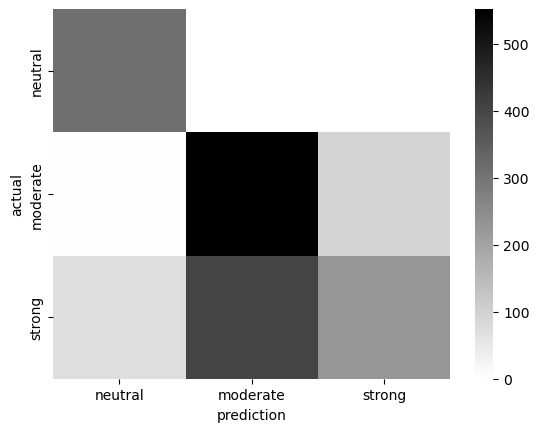

In [13]:
visualizeClassificationAreas_3x3(threebythree_s_confusion_matrix)

In [14]:
def visualizeClassificationAreas_3x3(confusion_matrix_threebythree):
    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    import seaborn as sns
    
# #     selection
#     categories_y = ['neutral', 'moderate', 'strong']
#     categories_x = ['neutral', 'moderate', 'strong']
#     mutation
    categories_y = ['high', 'medium', 'low']
    categories_x = ['high', 'medium', 'low']
    
    ax = sns.heatmap(confusion_matrix_threebythree, annot=False, fmt='.2%', cmap='binary')
    ax.set_xticklabels(categories_x)
    ax.set_yticklabels(categories_y)
    ax.set(xlabel='prediction', ylabel='actual')
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = np.array(confusion_matrix), display_labels = [False, True])

    # cm_display.plot()
    plt.savefig('stored_fourhit_models_inc_neutrality/subsample300models/graphs/with_sb_randomseed_20_mutation_confusion_matrix.pdf', bbox_inches = 'tight')


    plt.show()

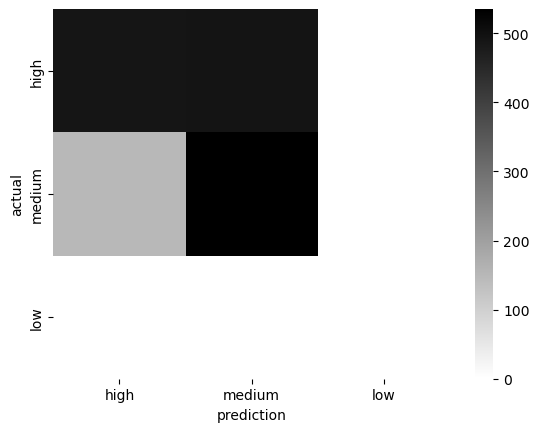

In [15]:
visualizeClassificationAreas_3x3(threebythree_mu_confusion_matrix)

# Testing consistency across 10 different models

In [9]:
# import 10 different model

imported_model_1 = NeuralNetwork()
imported_model_1.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_11_data_epoch_10000.pt'))
imported_model_1.eval()

imported_model_2 = NeuralNetwork()
imported_model_2.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_12_data_epoch_10000.pt'))
imported_model_2.eval()

imported_model_3 = NeuralNetwork()
imported_model_3.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_13_data_epoch_10000.pt'))
imported_model_3.eval()

imported_model_4 = NeuralNetwork()
imported_model_4.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_14_data_epoch_10000.pt'))
imported_model_4.eval()

imported_model_5 = NeuralNetwork()
imported_model_5.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_15_data_epoch_10000.pt'))
imported_model_5.eval()

imported_model_6 = NeuralNetwork()
imported_model_6.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_16_data_epoch_10000.pt'))
imported_model_6.eval()

imported_model_7 = NeuralNetwork()
imported_model_7.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_17_data_epoch_10000.pt'))
imported_model_7.eval()

imported_model_8 = NeuralNetwork()
imported_model_8.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_18_data_epoch_10000.pt'))
imported_model_8.eval()

imported_model_9 = NeuralNetwork()
imported_model_9.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_19_data_epoch_10000.pt'))
imported_model_9.eval()

imported_model_10 = NeuralNetwork()
imported_model_10.load_state_dict(torch.load('stored_fourhit_models_inc_neutrality/subsample300models/model_with_sb_randomseed_20_data_epoch_10000.pt'))
imported_model_10.eval()


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [12]:
# sample the test dataset only once
testing_data_1 = MyDataset('test')
testing_dataloader_1 = DataLoader(testing_data_1, batch_size=1, shuffle=False)

self.label tensor([0., 7., 1.,  ..., 6., 5., 1.])


In [1]:
from statistics import mode

def test_different_models(imported_model_1, dataloader):
    
    correct = 0
    predicted_class_list = {}
    actual_class_list = {}
    with torch.no_grad():
        for i, (subsampling1, actual_class_1) in enumerate(dataloader):
            predicted_class_list[i] = []
            pred = imported_model_1(subsampling1)
            predicted_class_1 = int(pred.argmax(1)[0])
            predicted_class_list[i].append(predicted_class_1)
            actual_class_list[i] = actual_class_1
            
        def evaluating_with_one_more_model(model):
            
            for k, (subsampling, actual_class) in enumerate(dataloader):
                pred = model(subsampling)
                predicted_class = int(pred.argmax(1)[0])
                predicted_class_list[k].append(predicted_class)
                
            return predicted_class_list
        
        evaluating_with_one_more_model(imported_model_2)
        evaluating_with_one_more_model(imported_model_3)
        evaluating_with_one_more_model(imported_model_4)
        evaluating_with_one_more_model(imported_model_5)
#         evaluating_with_one_more_model(imported_model_6)
#         evaluating_with_one_more_model(imported_model_7)
#         evaluating_with_one_more_model(imported_model_8)
#         evaluating_with_one_more_model(imported_model_9)
#         evaluating_with_one_more_model(imported_model_10)
            
        consensus_prediction = []
        for i, list_of_prediction in predicted_class_list.items():
#             print('i', i, 'list_of_prediction', list_of_prediction)      
            consensus_prediction.append(mode(list_of_prediction)) 


    return predicted_class_list, actual_class_list, consensus_prediction

predicted_class_list, actual_class_list, consensus_prediction = test_different_models(imported_model_1, testing_dataloader_1)

In [2]:
total_evaluated = 0
correct = 0
for i, actual_class in actual_class_list.items():
    total_evaluated +=1
    consensus = consensus_prediction[i]
    if consensus == actual_class:
        correct+=1
        
print('accuracy average across all of test data is', correct/total_evaluated)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import seaborn as sns
    
def output(j, predicted_class_list_dict, actual_class_list):
    
    actual_class = actual_class_list[j]
    predicted_class_list = predicted_class_list_dict[j]
    
    input_matrix = [[0,0,0],[0,0,0],[0,0,0]]
    
    column = actual_class % 3
    if actual_class >= 3:
        row = 1
    else:
        row = 0
    input_matrix[row][column]=1
    
    
    output_matrix = [[0,0,0],[0,0,0]]
    number_of_test_data_versions = len(predicted_class_list)
    for predicted_class in predicted_class_list:
        column = predicted_class % 3
        if predicted_class >= 3:
            row = 1
        else:
            row = 0
        output_matrix[row][column]+=1

    categories_x = ['$9\%$','$15\%$', '$21\%$']
    categories_y = ['high $\mu$', 'low $\mu$']

    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.subplots_adjust(wspace=0.01)

    sns.heatmap(input_matrix, annot=False, ax=ax1, fmt='.2%', cmap='Blues', cbar=False, vmin=0, vmax=1)
    ax1.set_xticklabels(categories_x, fontsize=20)
    ax1.set_yticklabels(categories_y, fontsize=20)
    ax1.set_xlabel('$s$', fontsize = 20)
    
    
    sns.heatmap(output_matrix, annot=False, ax=ax2,  fmt='.2%', cmap='BuPu', cbar=False, \
                vmin = 0, vmax = number_of_test_data_versions)
    
    ax2.set_xticklabels(categories_x, fontsize=20)
    ax2.set_yticklabels(categories_y, fontsize=20)
    ax2.set_xlabel('$s$', fontsize = 20)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = np.array(confusion_matrix), display_labels = [False, True])

#     cm_display.plot()
#     plt.savefig('four_hit_process_from_737/graphs/ensemble/Output_for_testdatum_'+str(j)+'_age60_80_six_classifier_vs_input.pdf', bbox_inches = 'tight')


    plt.show()